# NIFTY50 Single stocks analysis
**Notebook contains analysis and forecast on a single stock.**


Importing necessary packages

In [1]:
#!pip install livelossplot

In [1]:
from os import listdir
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from livelossplot import PlotLossesKeras
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')
%autosave 30

Autosaving every 30 seconds


In [2]:
#dft

In [3]:
dft = pd.read_csv(r'C:\Users\asuto\Desktop\Work\Datasets\NIFTY50\NIFTYMASTERDATA.csv',index_col='Date',parse_dates=True)

#url = 'https://raw.githubusercontent.com/AsutoshDalei/stock-work/main/NIFTYMASTERDATA.csv'
#dft = pd.read_csv(url,parse_dates=True)
#dft['Date'] = pd.to_datetime(dft['Date'])
#dft.set_index('Date',inplace = True)
dft

comps = dft.Symbol.unique()

In [4]:
dft

,Symbol,Prev Close,Open,High,Low,Close,Last,Volume,Turnover
Date,,,,,,,,,
2010-11-04,ADANIPORTS,159.90,161.0,163.00,160.30,161.20,161.05,835546,1.348395e+13
2010-11-05,ADANIPORTS,161.20,163.0,163.00,161.60,162.30,162.35,187158,3.037435e+12
2010-11-08,ADANIPORTS,162.30,162.5,163.45,160.20,161.40,161.30,613082,9.911300e+12
2010-11-09,ADANIPORTS,161.40,162.5,165.00,161.35,162.25,162.40,601933,9.825511e+12
2010-11-10,ADANIPORTS,162.25,162.5,162.90,159.55,159.90,160.00,423032,6.795621e+12
...,...,...,...,...,...,...,...,...,...
2021-04-26,ZEEL,188.00,190.6,191.10,185.10,186.40,186.70,8542755,1.600451e+14
2021-04-27,ZEEL,186.40,188.0,192.95,186.80,188.15,188.80,14247767,2.698636e+14
2021-04-28,ZEEL,188.15,188.8,190.60,187.10,189.10,188.95,8429439,1.591917e+14


## Below are the companies the model will be monitoring

In [5]:
comps

array(['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV',
       'BAJFINANCE', 'BHARTIARTL', 'BPCL', 'BRITANNIA', 'CIPLA',
       'COALINDIA', 'DRREDDY', 'EICHERMOT', 'GAIL', 'GRASIM', 'HCLTECH',
       'HDFC', 'HDFCBANK', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR',
       'ICICIBANK', 'INDUSINDBK', 'INFY', 'IOC', 'ITC', 'JSWSTEEL',
       'KOTAKBANK', 'LT', 'MARUTI', 'MM', 'NESTLEIND', 'NTPC', 'ONGC',
       'POWERGRID', 'RELIANCE', 'SBIN', 'SHREECEM', 'SUNPHARMA',
       'TATAMOTORS', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO',
       'UPL', 'VEDL', 'WIPRO', 'ZEEL'], dtype=object)

In [6]:
comp30 = ['INFY','TCS','RELIANCE','ICICIBANK','HDFC','HCLTECH','BHARTIARTL',
          'INDUSINDBK','SBIN','LT','TECHM','MM','AXISBANK','ITC','BAJAJ-AUTO','ONGC',
          'TATASTEEL','NTPC','TECHM','ASIANPAINT','POWERGRID','BAJAJFINSV','TITAN','NESTLEIND',
          'ULTRACEMCO','MARUTI','HDFCBANK','HINDUNILVR','SUNPHARMA','KOTAKBANK'  
         ]
len(comp30)

30

In [7]:
#comp30

## Various columns and the dataframe itself

In [8]:
cols = ['Symbol','Prev Close', 'Open', 'High', 'Low','Close' ,'Last','Volume', 'Turnover']
dft.head()

,Symbol,Prev Close,Open,High,Low,Close,Last,Volume,Turnover
Date,,,,,,,,,
2010-11-04,ADANIPORTS,159.90,161.0,163.00,160.30,161.20,161.05,835546,1.348395e+13
2010-11-05,ADANIPORTS,161.20,163.0,163.00,161.60,162.30,162.35,187158,3.037435e+12
2010-11-08,ADANIPORTS,162.30,162.5,163.45,160.20,161.40,161.30,613082,9.911300e+12
2010-11-09,ADANIPORTS,161.40,162.5,165.00,161.35,162.25,162.40,601933,9.825511e+12
2010-11-10,ADANIPORTS,162.25,162.5,162.90,159.55,159.90,160.00,423032,6.795621e+12


## Get Data Function

In [9]:
def get_data(stock,feature):
    return dft[dft.Symbol == stock][feature]

## Generate Data Function
**This function returns a dataframe containing the following features of a stock:**
- Opening Price
- Day wise difference
- Consecutive day opening price difference
- MACD Histogram value for the day
- RSI value for the day

These features are returned as a dataframe, which will later be used for time series forecasting.

In [10]:
def generate_data(stock,feature,slow=26,fast=12,smooth=9,lookback=14):
    op = get_data(stock,'Open') # Open
    cl = get_data(stock,'Close') # Close
    vol = get_data(stock,'Volume') # Volume
    #diff = cl-op # Daily Difference
    ewa1 = op.ewm(span=slow,min_periods=0,adjust=False).mean()
    datf = ewa1.diff() # Consecutive Day Difference
    ewa2 = op.ewm(span=fast,min_periods=0,adjust=False).mean()
    macd = ewa2-ewa1
    signal = macd.ewm(span=smooth,min_periods=0,adjust=False).mean().values
    hist = macd - signal # MACD Difference
    
    #datf = op.diff()
    
    up = []
    down = []
    for i in range(len(datf)):
        if datf[i] < 0:
            up.append(0)
            down.append(datf[i])
        else:
            up.append(datf[i])
            down.append(0)
            
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs)) # RSI
    
    final = {'open':op.values,'close':cl.values,'volume':vol,'cdiff':datf.values,
             'macdhist':hist.values,'rsi':rsi.values
            }
    
    df = pd.DataFrame(final)
    df.set_index(op.index,inplace=True)
    df.interpolate(limit_direction ='backward',methoh = 'linear',inplace=True)
    
    return df
    

In [11]:
%%time
df = generate_data('MARUTI','Open')
df.head()

CPU times: total: 31.2 ms
Wall time: 51.3 ms


,open,close,volume,cdiff,macdhist,rsi
Date,,,,,,
2010-11-04,1501.0,1507.60,352793,1.777778,0.000000,100.000000
2010-11-05,1525.0,1512.35,40103,1.777778,1.531624,100.000000
2010-11-08,1515.0,1488.60,228488,0.905350,1.769658,100.000000
2010-11-09,1490.0,1471.95,382790,-1.013565,0.223119,95.652653
2010-11-10,1475.0,1475.10,209770,-2.049597,-1.723215,87.380120


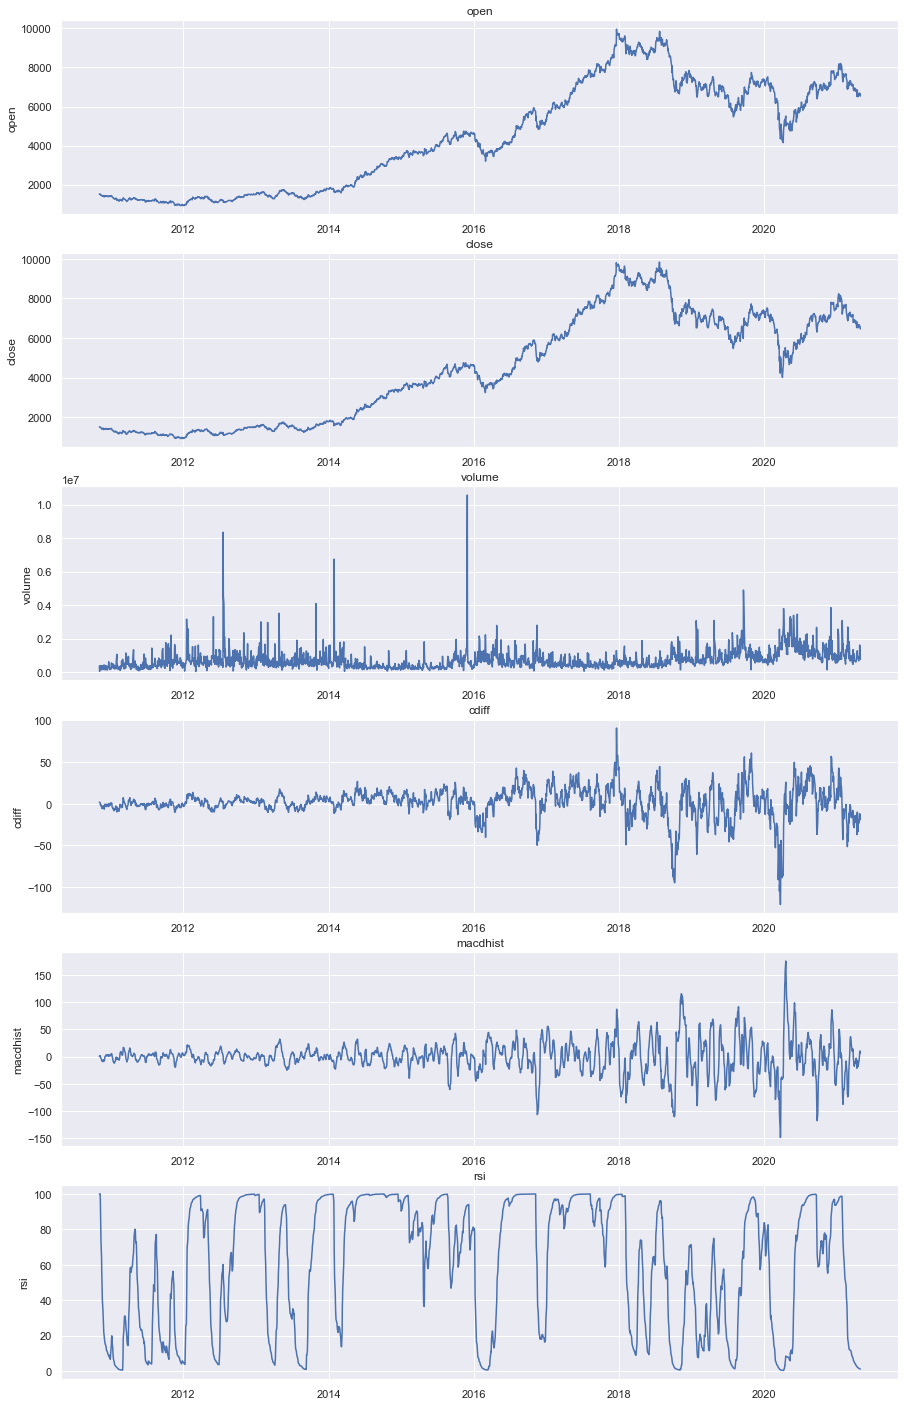

In [12]:
def plot_data(data):
    n = len(data.columns)
    plt.figure(figsize=(15,25))
    for i in range(n):
        plt.subplot(n,1,i+1)
        sns.lineplot(data = data,x = data.index, y = data.columns[i])
        plt.title(data.columns[i])
        plt.xlabel('')
        
plot_data(df)

In [13]:
df.shape

(2598, 6)

In [14]:
df.head()

,open,close,volume,cdiff,macdhist,rsi
Date,,,,,,
2010-11-04,1501.0,1507.60,352793,1.777778,0.000000,100.000000
2010-11-05,1525.0,1512.35,40103,1.777778,1.531624,100.000000
2010-11-08,1515.0,1488.60,228488,0.905350,1.769658,100.000000
2010-11-09,1490.0,1471.95,382790,-1.013565,0.223119,95.652653
2010-11-10,1475.0,1475.10,209770,-2.049597,-1.723215,87.380120


**For our task, the input data will be:** 
- Stock Opening Price
- Consecutive Day Difference
- MACD Histogram
- RSI

**While the target will be:**
- Daily Difference


In [15]:
ipfea = ['open','cdiff','macdhist','rsi','volume']
#opfea = ['close']
opfea = ['open']

**Since all our features are of a different scale, it is important for us to scale our data, for our model to run faster and not develop bias towards a higher scale feature** 

In [16]:
%%time
scaip = StandardScaler()
scaop = StandardScaler()
scaop.fit(df[opfea])
df[ipfea] = scaip.fit_transform(df[ipfea])

#df_sca = pd.DataFrame(sca.fit_transform(df),columns=df.columns)

CPU times: total: 0 ns
Wall time: 9.97 ms


In [17]:
scaop.mean_

array([4436.40948807])

In [18]:
def chunk(data,window=7,ahead=1):
    iparr,oparr = [],[]
    for i in tqdm(range(data.shape[0]-window-ahead)):
        iparr.append(data[ipfea].iloc[i:i+window])
        opt = data[opfea].iloc[i+window:i+window+ahead].values.ravel().tolist()
        #opt = data[opfea].iloc[i+window:i+window+ahead].values.ravel()
        oparr.append(opt)
        #oparr.append(data[opfea].iloc[i+window])
    iparr,oparr = np.array(iparr),np.array(oparr)
    #iparr = np.array(iparr)
    print(iparr.shape,oparr.shape)
    return iparr,oparr    
       

**We will keep data from start till 31/12/2020 for training and the data from 1/1/2021 for test**

In [19]:
%%time
date = '2021-01-01'
ips,ops = chunk(df.loc[:date],window = 10,ahead = 5)
ipt,opt = chunk(df.loc[date:],window = 10,ahead = 5)
#tt = chunk(df.loc[date:],ahead=2)

100%|█████████████████████████████████████████████████████████████████████████████| 2504/2504 [00:02<00:00, 955.01it/s]


(2504, 10, 5) (2504, 5)


100%|████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 1104.64it/s]

(65, 10, 5) (65, 5)
CPU times: total: 2.75 s
Wall time: 2.74 s


In [20]:
%%time
ipx,opx = shuffle(ips,ops,random_state=32)

CPU times: total: 0 ns
Wall time: 3.99 ms


## LSTM Model

In [21]:
import tensorflow as tf
from tensorflow import keras

In [22]:
bestparms = {'act': 'tanh',
 'batch': 32,
 'drp': 0.10761800034082002,
 'lr': 0.002304610672382999,
 'epoch': 55,
 'layers': 7,
 'units': 90}
bestparms

{'act': 'tanh',
 'batch': 32,
 'drp': 0.10761800034082002,
 'lr': 0.002304610672382999,
 'epoch': 55,
 'layers': 7,
 'units': 90}

In [23]:
act = bestparms['act']
drp = bestparms['drp']
model = tf.keras.models.Sequential([
                           tf.keras.layers.GRU(units=12,activation=act,return_sequences=True,
                                                input_shape=(ipx.shape[1],ipx.shape[2])),
                           tf.keras.layers.GRU(units=16,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=64,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
    
                           #tf.keras.layers.GRU(units=128,activation=act,return_sequences=True),
                           #tf.keras.layers.Dropout(drp),
                           #tf.keras.layers.GRU(units=128,activation=act,return_sequences=True),
                           #tf.keras.layers.Dropout(drp),
    
                           tf.keras.layers.GRU(units=64,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=16,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=10,activation='tanh',return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=7,activation=act),
                           tf.keras.layers.Dense(units=5)
                          ])

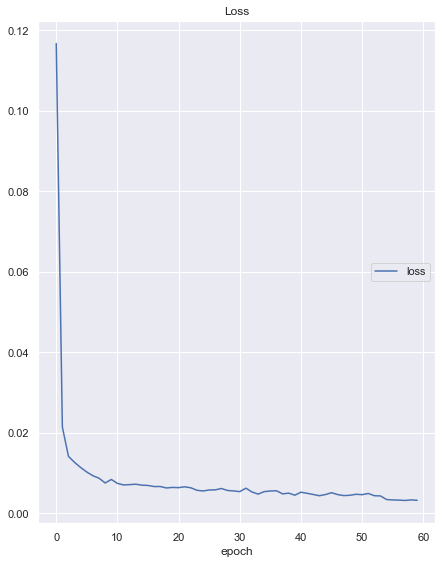

Loss
	loss             	 (min:    0.003, max:    0.117, cur:    0.003)
CPU times: total: 4min 44s
Wall time: 3min 55s


In [24]:
%%time
tf.keras.backend.clear_session()

opti = tf.optimizers.Adam(learning_rate=bestparms['lr'])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',min_lr=0.0001,factor = 0.05)
early_stp = tf.keras.callbacks.EarlyStopping('loss',patience=25)


model.compile(optimizer=opti,loss='mean_squared_error')
history=model.fit(ipx,opx,epochs=60,batch_size=16,verbose=0,callbacks=[PlotLossesKeras(),early_stp,reduce_lr])

In [26]:
model.save(r'C:\Users\asuto\Desktop\Work\Datasets\MODELBASE1.h5')
model.summary()
#model.save('./MODELBASE1.h5').

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 10, 12)            684       
_________________________________________________________________
gru_1 (GRU)                  (None, 10, 16)            1440      
_________________________________________________________________
dropout (Dropout)            (None, 10, 16)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 10, 64)            15744     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 10, 64)            24960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 64)            0

In [23]:
model = tf.keras.models.load_model(r'C:\Users\asuto\Desktop\Work\Datasets\MODELBASE1.h5')

In [24]:
opp = model.predict(ipt)

In [25]:
lossfn = tf.keras.losses.MeanSquaredError()
print(lossfn(opt,opp).numpy())

0.006272166


**Plot of actual versus predicted stock values.**

Predicted stock value is not being used for next step prediction.

53241.52734375


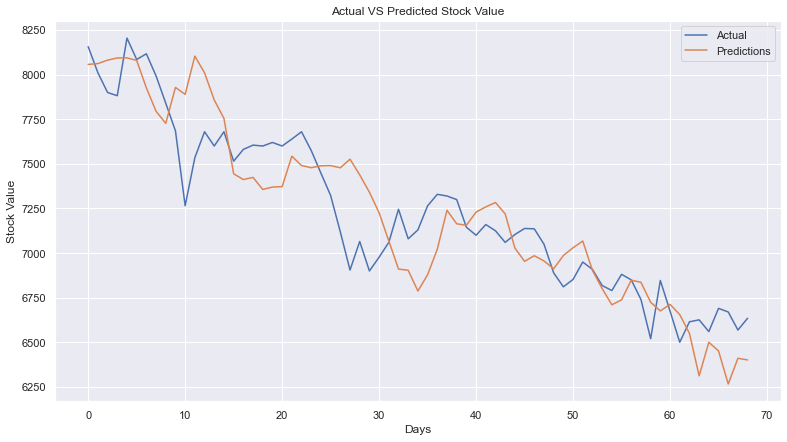

In [26]:
def plot_res(model=model,ipx=ipt,opx=opt,scaled = True):
    opp = model.predict(ipx)
    des = {'act':opx[0].tolist(),'pred':opp[0].tolist()}
    for i in range(1,len(opp)):
        des['act'].append(opx[i][-1])
        des['pred'].append(opp[i][-1])
    
    plt.figure(figsize=(13,7))
    if scaled:
        plt.plot(des['act'],label = 'Actual')
        plt.plot(des['pred'], label = 'Predictions')
        lossfn = tf.keras.losses.MeanSquaredError()
        print(lossfn(opx,opp).numpy())
    else:
        tt = np.array(des['act']).reshape(-1,1)
        tt
        scaop.inverse_transform(tt)
        opx1 = scaop.inverse_transform(np.array(des['act']).reshape(-1,1))
        opp1 = scaop.inverse_transform(np.array(des['pred']).reshape(-1,1))
        plt.plot(opx1,label = 'Actual')
        plt.plot(opp1, label = 'Predictions')
        lossfn = tf.keras.losses.MeanSquaredError()
        print(lossfn(opx1,opp1).numpy())
    
    plt.xlabel('Days')
    plt.ylabel('Stock Value')
    plt.title("Actual VS Predicted Stock Value")    
    plt.legend()
    return

plot_res(ipx=ipt,opx=opt,scaled = False)

In [77]:
def generate_data_x(op,slow=26,fast=12,smooth=9,lookback=14):
    #diff = cl-op # Daily Difference
    ewa1 = op.ewm(span=slow,min_periods=0,adjust=False).mean()
    datf = ewa1.diff() # Consecutive Day Difference
    ewa2 = op.ewm(span=fast,min_periods=0,adjust=False).mean()
    macd = ewa2-ewa1
    signal = macd.ewm(span=smooth,min_periods=0,adjust=False).mean().values
    hist = macd - signal # MACD Difference
    
    #datf = op.diff()
    
    up = []
    down = []
    for i in range(len(datf)):
        if datf[i] < 0:
            up.append(0)
            down.append(datf[i])
        else:
            up.append(datf[i])
            down.append(0)
            
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs)) # RSI
    
    final = {'open':op.values,'close':cl.values,'volume':vol,'cdiff':datf.values,
             'macdhist':hist.values,'rsi':rsi.values
            }
    
    df = pd.DataFrame(final)
    df.set_index(op.index,inplace=True)
    df.interpolate(limit_direction ='backward',method = 'linear',inplace=True)
    
    return df

def chunk(data,window=7,ahead=1):
    iparr,oparr = [],[]
    for i in tqdm(range(data.shape[0]-window-ahead)):
        iparr.append(data[ipfea].iloc[i:i+window])
        opt = data[opfea].iloc[i+window:i+window+ahead].values.ravel().tolist()
        #opt = data[opfea].iloc[i+window:i+window+ahead].values.ravel()
        oparr.append(opt)
        #oparr.append(data[opfea].iloc[i+window])
    iparr,oparr = np.array(iparr),np.array(oparr)
    #iparr = np.array(iparr)
    print(iparr.shape,oparr.shape)
    return iparr,oparr    
       

In [78]:
def plot_res_cycle(model=model,ipx=ipt,opx=opt,scaled = True):
    #opp = model.predict(ipx[0:2])
    opn = []
    for i in ipx:
        opn.append(i[0][0])
    opn = np.array(opn)
    opp = model.predict(ipx[-1].reshape(1,10,5))
    opn = np.concatenate([opn,opp[0]])
    for i in range(10):
        dft = generate_data_x(opn)
        ipy,opy = chunk(dft)
        opz = model.predict(ipy[-1].reshape(1,10,5))
        opn = np.concatenate([opn,opz[0]])
        
    return opn
plot_res_cycle(ipx=ips,opx=ops,scaled = False)

TypeError: generate_data_x() missing 1 required positional argument: 'feature'

In [76]:
len(ptr)

2509

In [66]:
dd

array([1.19568883, 1.22727568, 1.19791849, 1.19568883, 1.20386425,
       1.17562189, 1.36105528, 1.3840951 , 1.39412857, 1.38550722,
       1.3826644 , 1.3283536 , 1.28710489, 1.28041591, 1.40044594,
       1.35585274, 1.36774426, 1.32164604, 1.26480829, 1.20720874,
       1.05120686, 1.15143008, 1.20535069, 1.17562189, 1.20535069,
       1.14403504, 1.1685613 , 1.17755426, 1.17562189, 1.18309125,
       1.17562189, 1.19011468, 1.20533211, 1.1662759 , 1.11913717,
       1.07268592, 0.99680315, 0.91735293, 0.97681053, 0.91549488,
       0.94410885, 0.97495248, 1.0439233 , 0.98238468, 1.00096519,
       1.05109537, 1.07506422, 1.07157109, 1.06413889, 1.00653934,
       0.98981688, 1.01211349, 0.99910714, 0.9749339 , 0.99130332,
       1.00393807, 1.00319485, 0.97123638, 0.91140717, 0.88242159,
       0.89776909, 0.93407538, 0.91865357, 0.88511577, 0.87461778])

## 

## Transfer Learning Attempt

In [ ]:
def flow_fn(stock,model=model,feature = 'Open',scaled = False):
    dfl = generate_data(stock,'Open')
    
    scaipl = StandardScaler()
    scaopl = StandardScaler()
    dfl[ipfea] = scaipl.fit_transform(dfl[ipfea])
    dfl[opfea] = scaopl.fit_transform(dfl[opfea])
    #return dfl
    ipl,opl = chunk(dfl,window = 10,ahead = 5)
    
    plot_res(model = model,ipx = ipl,opx = opl,scaled = scaled)
    return

In [ ]:
%%time
stk = comp30[9]
stk = np.random.choice(comp30)
stk = 'MARUTI'
print(stk)
flow_fn(stock = stk)

**As we see, the model's predictions on different stocks are not greatly bad. There is scope of improvement which can be implement towards building a generalized model.**

## Optuna Hyper Parameter tuning

In [44]:
#!pip install optuna
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.layers import GRU,Dense

In [ ]:
def savebest(study, trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

def objective(trial):
    act = trial.suggest_categorical("act", ["tanh", "relu"])
    batch = trial.suggest_categorical("batch", [8,16,32,64,128])
    drp = trial.suggest_uniform('drp', 0.0, 0.7)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    epoch = trial.suggest_int("epoch", 30,55)
    
    layers = trial.suggest_int('layers',5,10)
    units = trial.suggest_int('units',64,256)
    
    monitor = "loss"
    callbacks = [TFKerasPruningCallback(trial, monitor)]
    #early_stop = EarlyStopping(monitor='val_loss',patience=3,min_delta = 0.0001)
    opti = tf.keras.optimizers.Adam(learning_rate=lr)
    
    global model
    
    model = tf.keras.models.Sequential()
    model.add(GRU(units=8,activation='tanh',return_sequences=True,input_shape=(ipx.shape[1],ipx.shape[2])))
    model.add(GRU(units=16,activation = act,return_sequences=True))
    model.add(tf.keras.layers.Dropout(drp))
    
    for lay in range(layers):
        model.add(GRU(units = units,activation=act,return_sequences=True))
        model.add(tf.keras.layers.Dropout(drp))
    
    model.add(GRU(units=16,activation = act,return_sequences=True))
    model.add(GRU(units=8,activation = act))
    model.add(Dense(units=1))

    tf.keras.backend.clear_session()
    model.compile(optimizer=opti,loss='mean_absolute_error')

    model.fit(ipx,opx, epochs = epoch, batch_size = batch,verbose = 0,
                     callbacks=callbacks)
    
    
    return model.evaluate(ipt,opt)

In [ ]:
%%time
study = optuna.create_study(direction='minimize', 
            pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective,n_trials = 50,callbacks=[savebest])

def savebest(study, trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

def objective(trial):
    act = trial.suggest_categorical("act", ["tanh", "relu"])
    batch = trial.suggest_categorical("batch", [16,32,64,128])
    drp = trial.suggest_uniform('drp', 0.0, 0.7)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    epoch = trial.suggest_int("epoch", 30,55)
    

    
    
    monitor = "loss"
    callbacks = [TFKerasPruningCallback(trial, monitor)]
    #early_stop = EarlyStopping(monitor='val_loss',patience=3,min_delta = 0.0001)
    opti = tf.keras.optimizers.Adam(learning_rate=lr)
    
    global model
    drp = 0.2
    model = tf.keras.models.Sequential([
                           tf.keras.layers.GRU(units=8,activation=act,return_sequences=True,
                                                input_shape=(ipx.shape[1],ipx.shape[2])),
                           tf.keras.layers.GRU(units=16,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=64,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
    
                           tf.keras.layers.GRU(units=128,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=128,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
    
                           tf.keras.layers.GRU(units=64,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=16,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=8,activation='tanh',return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=4,activation=act),
                           tf.keras.layers.Dense(units=1)
                          ])
    
    tf.keras.backend.clear_session()
    model.compile(optimizer=opti,loss='mean_absolute_error')

    model.fit(ipx,opx, epochs = epoch, batch_size = batch,verbose = 0,
                     callbacks=callbacks)
    
    
    return model.evaluate(ipt,opt)

%%time
study = optuna.create_study(direction='minimize', 
            pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective,n_trials = 70,callbacks=[savebest])

In [ ]:
best_params = study.best_params
best_params

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_intermediate_values(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
plot_res(model = best_model,ipx=ipt,opx=opt,scaled = False)

In [ ]:
%%time
stk = comp30[9]
#stk = 'MARUTI'
stk = np.random.choice(comp30)
print(stk)
flow_fn(stock = stk,model = model)

In [ ]:
def prepdata(features,ime,data, jump = 1,lookup =  14,targets=2):
    ipdat,opdat = [],[]
    data = data[data.imei == ime]
    if targets == 3:
        data = pd.get_dummies(data,columns=['zone'])
        #data = data.replace(['good','warning','critical'],[0,1,2])
    else:
        data = data.replace(['good','warning','critical'],[0,0,1])
        
    for i in range(0,len(data)-lookup, jump):
        if len(features) == 1:
            res = data[i:i+lookup][features[0]].values
        else:
            res = data[i:i+lookup][features].values
        
        #CHANGE HERE FOR 2D-3D FORM OF I/P DATA
        #ipdat.append(np.ravel(res))
        ipdat.append(res)
        
        if targets == 3:
            y = data[['zone_good','zone_warning','zone_critical']].iloc[i+lookup-1].values
        else:
            y = data['zone'].iloc[i+lookup-1]
        #print(y)
        opdat.append(y) 
    
    ipdat = np.array(ipdat)
    opdat = np.array(opdat)
    #print(ipdat.shape, opdat.shape)
    return ipdat,opdat


def pushdata(features,arr, lookup = 14,scale = False,targets=2):
    flag = True
    jump = 1
    for i in tqdm(arr):
        if datafull[datafull.imei == i].shape[0] < 100:
            continue
        if flag:
            ipt,opt = prepdata(features,ime = i, jump = jump, lookup = lookup,targets = targets)
            flag = False
            continue 
        a,b = prepdata(features,ime = i,  jump = jump, lookup = lookup,targets = targets)
        ipt = np.concatenate((ipt,a))
        opt = np.concatenate((opt,b))
    print(ipt.shape,opt.shape)
    return ipt,opt

